# HW3 : Path Following Solver

## Import Libraries

In [2]:
## Importing the libraries

from sklearn.decomposition import PCA
import numpy as np
from derivative import *
from HW3_B2 import *
from HW3_B4 import several_newton
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from progress.bar import Bar
from alive_progress import alive_bar
from tools import *
import time
from sklearn.metrics import accuracy_score

## Long & Short Steps Solver Implementation

### Short Step

In [3]:

def short_step_method(class_A, class_B, lambda_param, nu, epsilon):

    nA, n = class_A.vectors.shape
    nB = class_B.vectors.shape[0]

    C = c_coeff(n, nA, nB, lambda_param)

    tau = 1/4
    theta = 1/(16*np.sqrt(nu))

    h, c, s, t, v, mu = init(class_A, class_B)
    mu_final = epsilon * (1 - tau) / nu
    nmax = int(np.ceil(np.log(mu_final/mu)/np.log(1 - theta)))
    ite = 0
    with alive_bar(nmax) as bar:
        while mu > mu_final:
            mu *= (1 - theta)
            step = newton_step(h, c, s, t, v, class_A, class_B, mu, lambda_param, C)
            h, s, t, c, v = uptade(h, s, t, c, v, step)
            ite += 1
            bar()

    return h, c, s, t, v, ite


### Long Step

In [4]:
def long_step_method(class_A, class_B, lambda_param, nu, epsilon, theta, tau):

    h, c, s, t, v, mu = init(class_A, class_B)

    nA, n = class_A.vectors.shape
    nB = class_B.vectors.shape[0]

    C = c_coeff(n, nA, nB, lambda_param)


    mu_final = epsilon * (1 - tau) / nu
    nmax = int(np.ceil(np.log(mu_final/mu)/np.log(1 - theta)))
    ite = 0
    with alive_bar(nmax) as bar:
        while mu > mu_final:
            mu *= (1 - theta)
            h, s, t, c, v = several_newton(h, c, s, t, v, class_A, class_B, mu, lambda_param, C, tau)
            ite += 1
            bar()


    return h, c, s, t, v, ite



## Question B3


### Code

In [5]:
## Import the data 
train_imgs, test_imgs, train_labels, test_labels = import_data(use_pca = True, n_pca=5) 

# set PCA to False if you want to use full dimensionnal data but the short step might be very long ...
# Note in the report we use the full dimensionnal data

In [6]:
nImage = [2, 3, 4, 5, 6, 7, 8, 9, 10]
timeCPU = []
nIte = []

epsilon = 1e-4
lambda_param = 1

for n in nImage:

    class_A, class_B = get_class(n, train_imgs, train_labels)
    nu = 2*len(class_A.vectors) + 2*len(class_B.vectors) + 2


    # Run the optimization
    t0 = time.process_time()
    _, _, _,  _, _, ite = short_step_method(class_A, class_B, lambda_param, nu, epsilon)
    tf  = time.process_time()

    timeCPU.append(tf - t0)
    nIte.append(ite)    

|█▌⚠︎                                     | (!) 37/1000 [4%] in 0.0s (790.99/s) 
|████████████████████████████████████████| 1923/1923 [100%] in 0.7s (2583.13/s) 
|█▉⚠︎                                     | (!) 47/1000 [5%] in 0.0s (1529.90/s) 
|████████████████████████████████████████| 2357/2357 [100%] in 1.2s (1900.87/s) 
|██▏⚠︎                                    | (!) 53/1000 [5%] in 0.0s (1182.35/s) 
|████████████████████████████████████████| 2725/2725 [100%] in 1.8s (1502.75/s) 
|██▌⚠︎                                    | (!) 62/1000 [6%] in 0.1s (430.96/s) 
|████████████████████████████████████████| 3115/3115 [100%] in 4.6s (670.55/s) 
|██▋⚠︎                                    | (!) 66/1000 [7%] in 0.1s (549.79/s) 
|████████████████████████████████████████| 3410/3410 [100%] in 5.6s (612.93/s) 
|██▉⚠︎                                    | (!) 71/1000 [7%] in 0.2s (340.43/s) 
|████████████████████████████████████████| 3681/3681 [100%] in 7.7s (480.50/s) 
|███⚠︎                       

### Results

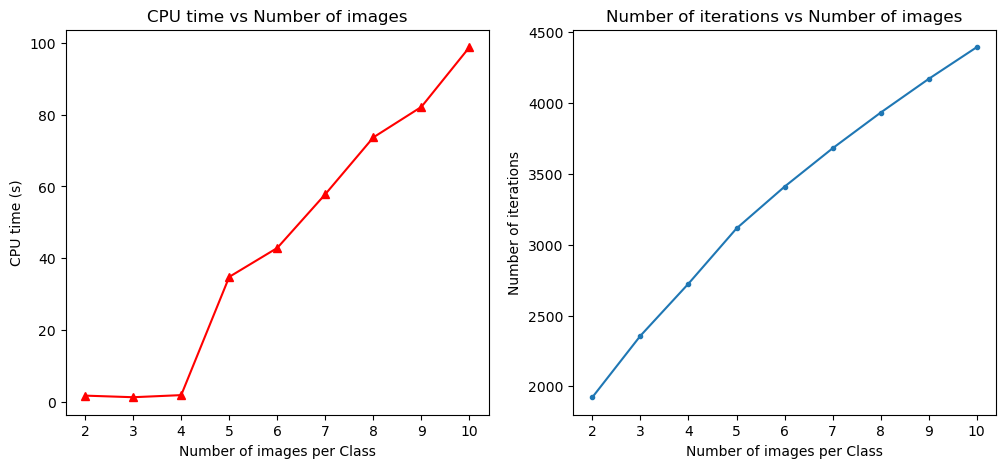

In [7]:

fig , ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()

ax[0].plot(nImage, timeCPU, "^-", color = "red")
ax[0].set_xlabel("Number of images per Class")
ax[0].set_ylabel("CPU time (s)")
ax[0].set_title("CPU time vs Number of images")

ax[1].plot(nImage, nIte, ".-")
ax[1].set_xlabel("Number of images per Class")
ax[1].set_ylabel("Number of iterations")
ax[1].set_title("Number of iterations vs Number of images")

plt.show()

## Question B4

### Code

#### With PCA (3min 30sec to run)

In [8]:
nImage_long_pca = np.arange(5, 55, 5)
timeCPU_long_pca = []
nIte_long_pca = []

theta = .95
epsilon = 1e-4
lambda_param = 1
tau = .2

for n in nImage_long_pca:

    class_A, class_B = get_class(n, train_imgs, train_labels)
    nu = 2*len(class_A.vectors) + len(class_B.vectors) + 2

    # Run the optimization
    t0 = time.process_time()
    _, _, _,  _, _, ite = long_step_method(class_A, class_B, lambda_param, nu, epsilon, theta, tau)
    tf  = time.process_time()

    timeCPU_long_pca.append(tf - t0)
    nIte_long_pca.append(ite)

|██▌⚠︎                                    | (!) 62/1000 [6%] in 0.1s (520.72/s) 
|████████████████████████████████████████| 5/5 [100%] in 0.5s (10.56/s) 
|███▎⚠︎                                   | (!) 82/1000 [8%] in 0.3s (296.05/s) 
|████████████████████████████████████████| 5/5 [100%] in 1.4s (3.61/s) 
|████⚠︎                                   | (!) 101/1000 [10%] in 1.0s (104.47/s) 
|████████████████████████████████████████| 5/5 [100%] in 2.5s (2.04/s) 
|████▋⚠︎                                  | (!) 116/1000 [12%] in 1.1s (101.81/s) 
|████████████████████████████████████████| 5/5 [100%] in 4.1s (1.23/s) 
|█████▏⚠︎                                 | (!) 129/1000 [13%] in 1.5s (86.98/s) 
|████████████████████████████████████████| 5/5 [100%] in 6.1s (0.81/s) 
|█████▋⚠︎                                 | (!) 140/1000 [14%] in 2.6s (53.22/s) 
|████████████████████████████████████████| 5/5 [100%] in 7.2s (0.70/s) 
|██████▍⚠︎                                | (!) 160/1000 [16%] in 3.3s (47.

#### Without PCA ( 3min 40 to run)

In [ ]:
## Reimport the data without the PCA
train_imgs, test_imgs, train_labels, test_labels = import_data()

In [ ]:
nImage_long = np.arange(5,15, 5) # We don't go further than 15 images because it will take too much time otherwise
timeCPU_long = []
nIte_long = []

theta = .95
epsilon = 1e-4
lambda_param = 1
tau = .2

for n in nImage_long:

    class_A, class_B = get_class(n, train_imgs, train_labels)
    nu = 2*len(class_A.vectors) + len(class_B.vectors) + 2


    # Run the optimization
    t0 = time.process_time()
    _, _, _,  _, _, ite = long_step_method(class_A, class_B, lambda_param, nu, epsilon, theta, tau)
    tf  = time.process_time()

    timeCPU_long.append(tf - t0)
    nIte_long.append(ite)

|██▌⚠︎                                    | (!) 62/1000 [6%] in 6.4s (9.65/s) 
|████████████████████████████████████████| 6/6 [100%] in 43.0s (0.14/s) 
|███▍⚠︎                                   | (!) 83/1000 [8%] in 15.5s (5.35/s) 
|████████████████████████████████████████| 6/6 [100%] in 1:51.7 (0.05/s) 


### Results

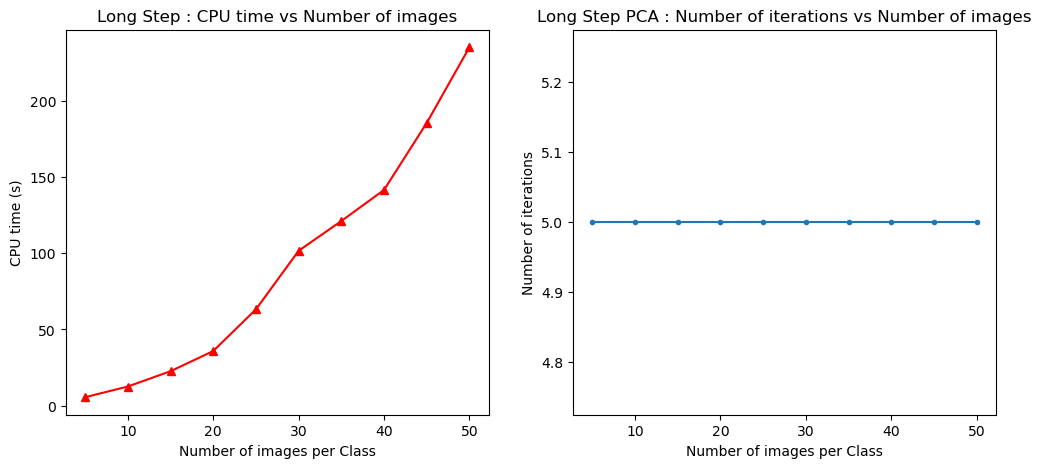

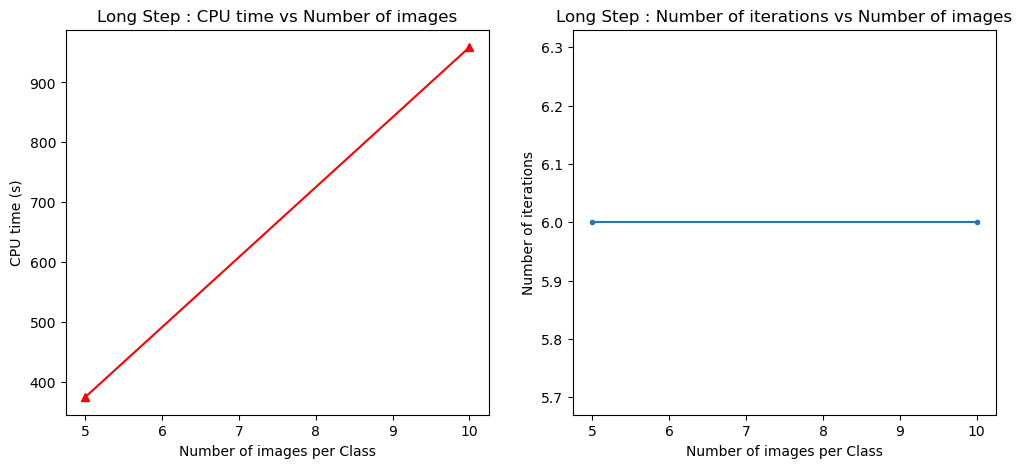

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()

ax[0].plot(nImage_long_pca, timeCPU_long_pca, "^-", color = "red")
ax[0].set_xlabel("Number of images per Class")
ax[0].set_ylabel("CPU time (s)")
ax[0].set_title("Long Step : CPU time vs Number of images")

ax[1].plot(nImage_long_pca, nIte_long_pca, ".-")
ax[1].set_xlabel("Number of images per Class")
ax[1].set_ylabel("Number of iterations")
ax[1].set_title("Long Step PCA : Number of iterations vs Number of images")

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()

ax[0].plot(nImage_long, timeCPU_long, "^-", color = "red")
ax[0].set_xlabel("Number of images per Class")
ax[0].set_ylabel("CPU time (s)")
ax[0].set_title("Long Step : CPU time vs Number of images")

ax[1].plot(nImage_long, nIte_long, ".-")
ax[1].set_xlabel("Number of images per Class")
ax[1].set_ylabel("Number of iterations")
ax[1].set_title("Long Step : Number of iterations vs Number of images")

plt.show()

## Question C1

### Code

In [ ]:
## Import the data

NIMAGE = 10 # to change 

train_imgs, test_imgs, train_labels, test_labels = import_data(use_pca = True, n_pca=5) # we use the PCA
class_A, class_B = get_class(NIMAGE, train_imgs, train_labels)

NameError: name 'import_data' is not defined

In [ ]:
## Lambdas

lambda_param = [.01, .02, .03, .05, .1, .4, .5, 1, 10, 50, 100, 1000]
nu = 2 * len(class_A.vectors) + 2 * len(class_B.vectors) + 2
epsilon = 1e-4
theta = .95
tau = .2
acc = [] 

for lam in lambda_param:
    h, c, s, t, v, ite = long_step_method(class_A, class_B, lam, nu, epsilon, theta, tau)

    ypred = np.array([classify(x, h, c) for x in train_imgs])
    ytrue = (train_labels > 0)*1.0
    acc.append(accuracy_score(ytrue, ypred))


### Results

Training Accuracy vs Lambda:  0.8103333333333333 0.8152833333333334 0.7866833333333333 0.8362666666666667 0.8870166666666667 0.9393166666666667 0.9433833333333334 0.9558833333333333 0.9578666666666666 0.9578666666666666 0.9578666666666666 0.9578333333333333


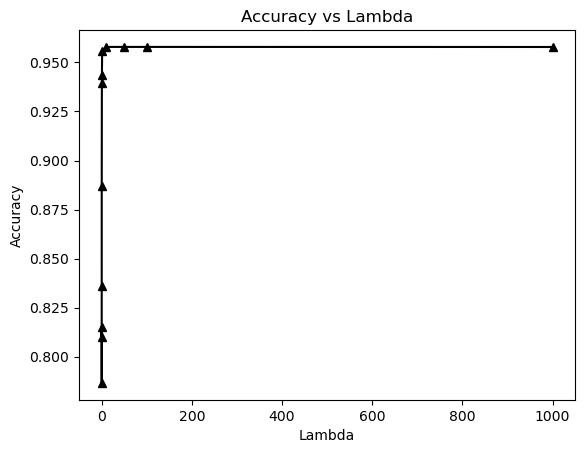

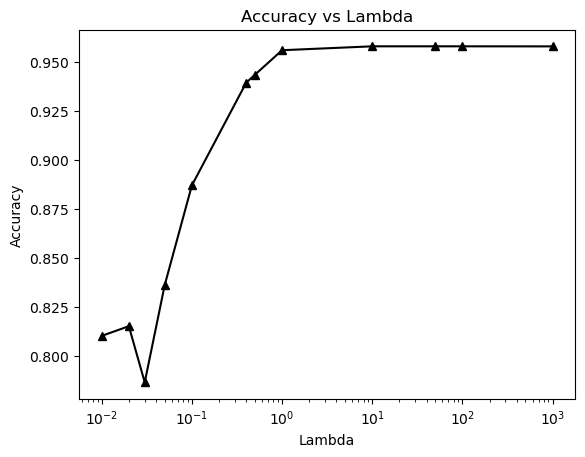

In [ ]:
print("Training Accuracy vs Lambda: ", *acc)

## Normal scale
plt.figure()
plt.plot(lambda_param, acc, "^-", color = "black")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Lambda")
# plt.savefig("lambdas_acc.pdf")
plt.show()

## Log scale
plt.figure()   
plt.plot(lambda_param, acc, "^-", color = "black")
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Lambda")
plt.xscale("log")
# plt.savefig("lambdas_acc_log.pdf")
plt.show()

## Question C2

### Code

In [ ]:
## We take the best lambda
lambda_final = lambda_param[np.argmax(acc)]
nu = 2 * len(class_A.vectors) + 2 * len(class_B.vectors) + 2
epsilon = 1e-4
theta = .95
tau = .2


## Training the model
h, c, s, t, v, ite  = long_step_method(class_A, class_B, lambda_final, nu, epsilon, theta, tau)

|████▋⚠︎                                  | (!) 117/1000 [12%] in 1.1s (106.63/s) 
|████████████████████████████████████████| 3/3 [100%] in 4.2s (0.72/s) 


### Results

In [ ]:
## Testing the model

ypred = np.array([classify(x, h, c) for x in test_imgs])
ytrue = (test_labels > 0)*1.0

print("Best Lambda : ", lambda_final)
print("Testing Accuracy: ", accuracy_score(ytrue, ypred))

Best Lambda :  10
Testing Accuracy:  0.9567
